# Descriptive Statistics

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv("../data/outputs/reddit_data_VAR_100p_15c_13sr.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921 entries, 0 to 8920
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       8921 non-null   int64  
 1   post_id          8921 non-null   object 
 2   title            8921 non-null   object 
 3   author           8921 non-null   object 
 4   author_flair     6000 non-null   object 
 5   score            8921 non-null   float64
 6   upvote_ratio     8921 non-null   float64
 7   post_date        8921 non-null   object 
 8   subreddit        8921 non-null   object 
 9   search_query     8921 non-null   object 
 10  comment_id       8921 non-null   object 
 11  comment_content  8920 non-null   object 
 12  comment_author   8921 non-null   object 
 13  comment_score    8921 non-null   float64
 14  comment_date     8921 non-null   object 
dtypes: float64(3), int64(1), object(11)
memory usage: 1.0+ MB


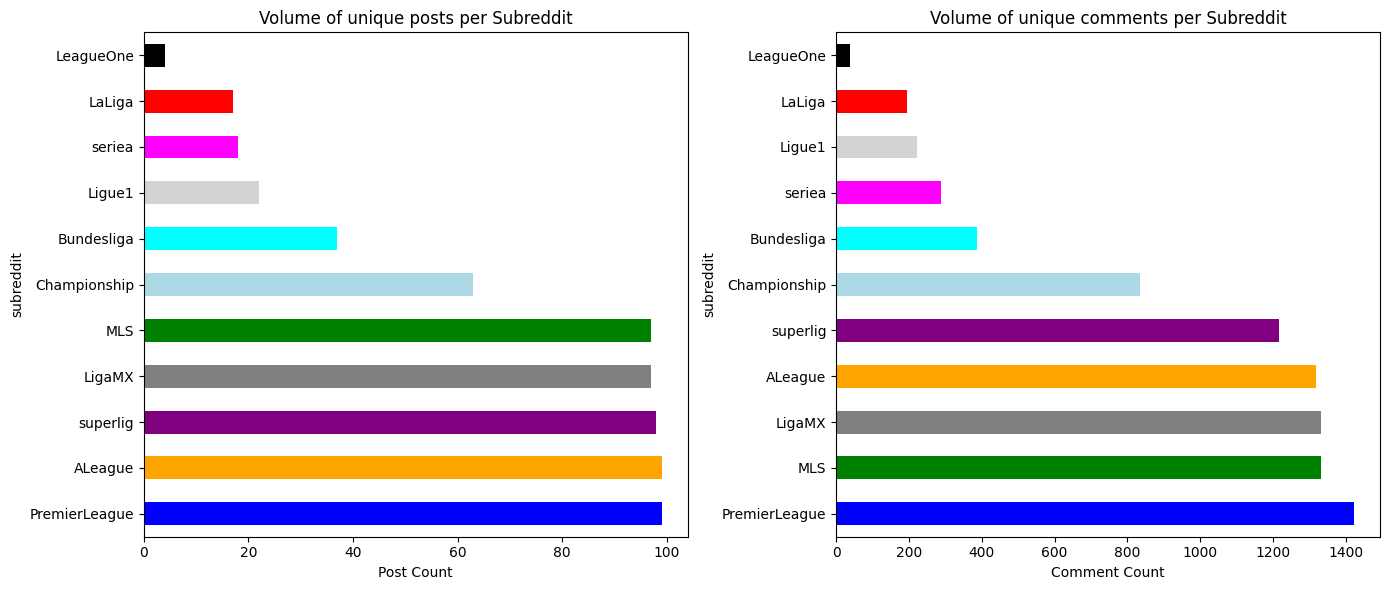

In [2]:
colour_map = {
    'PremierLeague': "blue",
    'LaLiga': "red",
    'MLS': "green",
    'Bundesliga': "cyan",
    'seriea': "magenta",
    'Championship': "lightblue",
    'LeagueOne': "black",
    'Ligue1': "lightgray",
    'LigaMX': "gray",
    'ALeague': "orange",
    'superlig': "purple"
}


fig = plt.figure(figsize=(14, 6))
ax1, ax2 = fig.subplots(ncols=2)

# Subreddit Post Counts
subr_p_counts = data[["title", "subreddit"]].drop_duplicates().subreddit.value_counts()
subr_p_colours = [colour_map[nm] for nm in subr_p_counts.index]
subr_p_counts.plot(kind="barh", color=subr_p_colours, ax=ax1)
ax1.set_title("Volume of unique posts per Subreddit")
ax1.set_xlabel("Post Count")

# Subreddit Comment Counts
subr_c_counts = data[["comment_content", "subreddit"]].drop_duplicates().subreddit.value_counts()
subr_c_colours = [colour_map[nm] for nm in subr_c_counts.index]
subr_c_counts.plot(kind="barh", color=subr_c_colours, ax=ax2)
ax2.set_title("Volume of unique comments per Subreddit")
ax2.set_xlabel("Comment Count")

fig.tight_layout()

In [3]:
print(f"The dataset contains {subr_p_counts.sum()} posts and {subr_c_counts.sum()} comments.")
print(f"The dataset ranges from {data.post_date.min()} to {data.post_date.max()}")

The dataset contains 651 posts and 8581 comments.
The dataset ranges from 2016-06-02 14:09:35 to 2025-05-25 22:04:17


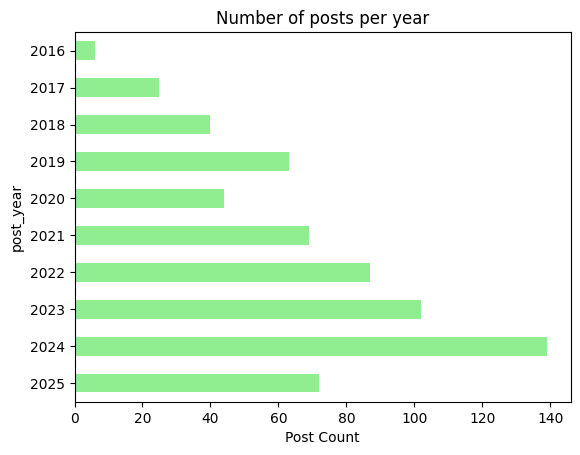

In [4]:
data["post_year"] = data["post_date"].apply(lambda x: int(x.split("-")[0]))

fig = plt.figure()
ax1 = fig.subplots()
data[["title", "post_year"]].drop_duplicates().post_year.value_counts().sort_index(ascending=False).plot(kind="barh", ax=ax1, color="lightgreen")
ax1.set_title("Number of posts per year")
ax1.set_xlabel("Post Count");

# Pre-Processing

## Date Range Filtering

In [5]:
# Filter data to posts from 2018 onwards
data["post_year"] = data.post_year.astype("int")
data = data[data.post_year >= 2018]

# Print stats
subr_p_counts = data[["title", "subreddit"]].drop_duplicates().subreddit.value_counts()
subr_c_counts = data[["comment_content", "subreddit"]].drop_duplicates().subreddit.value_counts()
print(f"The dataset contains {subr_p_counts.sum()} posts and {subr_c_counts.sum()} comments.")

The dataset contains 620 posts and 8223 comments.


## Text Cleaning

### Bot Account Removal

In [6]:
# Standard Lib Imports
import re

# 3rd Part Imports
import numpy as np

# regex for bot usernames
bot_pattern = re.compile(
    r"(?i)(bot|auto|moderator|test|dummy|temp)[\d]*\b",
    re.IGNORECASE  # Case insensitive matching
)

# Get Bot Usernames
bot_users = []
for user in np.union1d(data.author.unique(), data.comment_author.unique()):
    if bot_pattern.search(user):
        bot_users.append(user)

bot_users

['AutoModerator',
 'KatnissBot',
 'LigaMXMatchBot',
 'MLS_Reddit_Bot',
 'PlebBot69',
 'SportsThreadderBot',
 'TheRobot64',
 'tweettranscriberbot',
 'twitterInfo_bot']

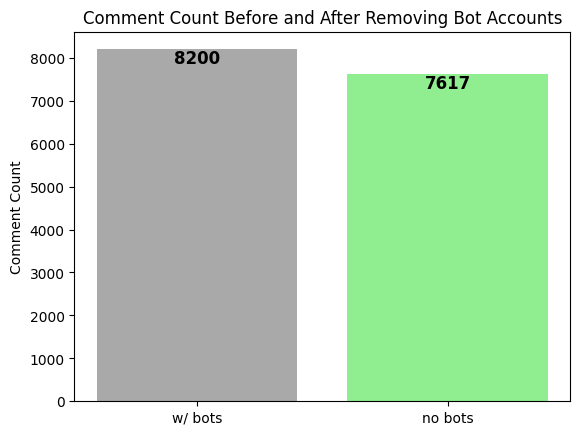

In [7]:
# Removes Bot Accounts
before = data.comment_content.drop_duplicates().count()
data = data[~(data["comment_author"].isin(bot_users) | data["author"].isin(bot_users))]
after = data.comment_content.drop_duplicates().count()

# Plot
fig = plt.figure()
ax1 = fig.subplots()
bars = ax1.bar(["w/ bots", "no bots"], [before, after], color=["darkgrey", "lightgreen"])
for bar, count in zip(bars, [before, after]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), 
             ha='center', va='top', fontsize=12, fontweight='bold')
ax1.set_ylabel("Comment Count")
ax1.set_title("Comment Count Before and After Removing Bot Accounts")

# Drop the author column
data.drop("author", axis=1, inplace=True)

### URL and '#' Removal

In [8]:
# Regex for URLs and #
removal_pattern = re.compile(r"\S*https?://\S+|#\S+", re.IGNORECASE)
whitespace_pattern = re.compile(r"\s+")

for col in ["title", "comment_content"]:
    # remove URLs and Hashtags (#)
    data[f"{col}_preprocessed"] = data[col].apply(lambda x: removal_pattern.sub(" ", str(x)))
    # remove new line strings (\n)
    data[f"{col}_preprocessed"] = data[f"{col}_preprocessed"].apply(lambda x: str(x).replace(r"\n", " "))
    # ensure white spaces are only one character
    data[f"{col}_preprocessed"] = data[f"{col}_preprocessed"].apply(
        lambda x: whitespace_pattern.sub(" ", str(x))
    )
 

### Punctuation Removal

In [9]:
# Remove neutral punctuation
punc_pattern = re.compile(r"""[.,:;()

\[\]

'\"]""")
for col in ["title_preprocessed", "comment_content_preprocessed"]:
    data[col] = data[col].apply(lambda x: punc_pattern.sub("", str(x)))

## Language Detection

In [10]:
from langdetect import detect, DetectorFactory, LangDetectException

# Create language detector
def detect_language(x):
    try:
        return(detect(x))
    except LangDetectException:
        return "NA"

DetectorFactory.seed = 0

# Detect language and remove posts
data["post_detected_lang"] = data["title_preprocessed"].apply(lambda x: detect_language(x))
print(f"Removing {len(data[data.post_detected_lang=='NA'])} posts from the dataset since a language can't be detected.")
data = data[data["post_detected_lang"]!="NA"]

# Detect language and remove comments
data["comment_detected_lang"] = data["comment_content_preprocessed"].apply(lambda x: detect_language(x))
print(f"Removing {len(data[data.comment_detected_lang=='NA'])} comments from the dataset since a language can't be detected.")
data = data[data["comment_detected_lang"]!="NA"]

Removing 0 posts from the dataset since a language can't be detected.
Removing 53 comments from the dataset since a language can't be detected.


In [11]:
accepted_languages = [
    "en",  # English
    "zh",  # Chinese (中文)
    "es",  # Spanish (Español)
    "hi",  # Hindi (हिन्दी)
    "ar",  # Arabic (العربية)
    "bn",  # Bengali (বাংলা)
    "pt",  # Portuguese (Português)
    "ru",  # Russian (Русский)
    "ja",  # Japanese (日本語)
    "de",  # German (Deutsch)
    "ms",  # Malay (Bahasa Melayu)
    "te",  # Telugu (తెలుగు)
    "vi",  # Vietnamese (Tiếng Việt)
    "ko",  # Korean (한국어)
    "fr",  # French (Français)
    "tr",  # Turkish (Türkçe)
    "it",  # Italian (Italiano)
    "pl",  # Polish (Polski)
    "uk",  # Ukrainian (Українська)
    "tl",  # Tagalog
    "nl",  # Dutch (Nederlands)
    "de",  # Swiss German (Schweizerdeutsch, same as standard German)
]

# Remove unsupported posts
print(f"Removing {len(data[~data.post_detected_lang.isin(accepted_languages)].title_preprocessed.unique())} posts since they are in unsupported languages.")
data = data[data.post_detected_lang.isin(accepted_languages)]

# Remove unsupported comments
print(f"Removing {len(data[~data.comment_detected_lang.isin(accepted_languages)])} comments since they are in unsupported languages.")
data = data[data.comment_detected_lang.isin(accepted_languages)]

Removing 17 posts since they are in unsupported languages.
Removing 360 comments since they are in unsupported languages.


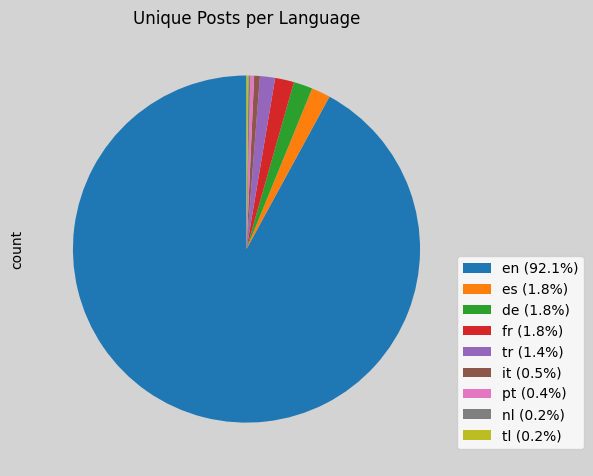

In [12]:
# Subreddit Post Counts
fig = plt.figure(figsize=(6, 6))
fig.patch.set_facecolor("lightgrey")
ax1 = fig.subplots()

subr_p_counts = data[["post_detected_lang", "title_preprocessed"]].drop_duplicates().post_detected_lang.value_counts()
post_labels = [f"{lang} ({count/sum(subr_p_counts)*100:.1f}%)" for lang, count in subr_p_counts.items()]
subr_p_counts.plot(kind="pie", ax=ax1, startangle=90, legend=False, labels=None)
ax1.set_title("Unique Posts per Language")
ax1.legend(post_labels, loc="best", bbox_to_anchor=(0.97, 0.5))

fig.tight_layout()

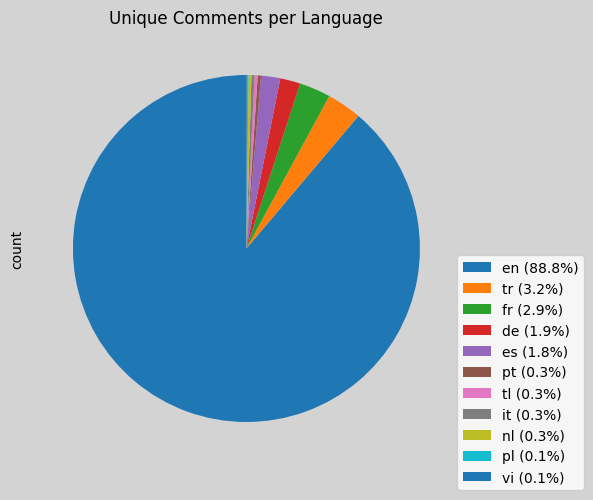

In [13]:
# Subreddit Comment Counts
fig = plt.figure(figsize=(6, 6))
fig.patch.set_facecolor("lightgrey")
ax1 = fig.subplots()

subr_c_counts = data[["comment_detected_lang", "comment_content_preprocessed"]].drop_duplicates().comment_detected_lang.value_counts()
comment_labels = [f"{lang} ({count/sum(subr_c_counts)*100:.1f}%)" for lang, count in subr_c_counts.items()]
subr_c_counts.plot(kind="pie", ax=ax1, startangle=90, legend=False, labels=None)
ax1.set_title("Unique Comments per Language")
ax1.legend(comment_labels, loc="best", bbox_to_anchor=(0.97, 0.5))

fig.tight_layout()

## Model Loading

In [14]:
import spacy

spacy_language_packs = {
    "en": "en_core_web_sm",  # English
    "zh": "zh_core_web_sm",  # Chinese
    "es": "es_core_news_sm",  # Spanish
    "hi": "xx_ent_wiki_sm",  # Hindi (No dedicated spaCy model, uses multi-language)
    "ar": "xx_ent_wiki_sm",  # Arabic (No dedicated spaCy model)
    "bn": "xx_ent_wiki_sm",  # Bengali (No dedicated spaCy model)
    "pt": "pt_core_news_sm",  # Portuguese
    "ru": "ru_core_news_sm",  # Russian
    "ja": "ja_core_news_sm",  # Japanese
    "de": "de_core_news_sm",  # German
    "ms": "xx_ent_wiki_sm",  # Malay (No dedicated spaCy model)
    "te": "xx_ent_wiki_sm",  # Telugu (No dedicated spaCy model)
    "vi": "xx_ent_wiki_sm",  # Vietnamese (No dedicated spaCy model)
    "ko": "xx_ent_wiki_sm",  # Korean (No dedicated spaCy model)
    "fr": "fr_core_news_sm",  # French
    "tr": "xx_ent_wiki_sm",  # Turkish (No dedicated spaCy model)
    "it": "it_core_news_sm",  # Italian
    "pl": "pl_core_news_sm",  # Polish
    "uk": "xx_ent_wiki_sm",  # Ukrainian (No dedicated spaCy model)
    "tl": "xx_ent_wiki_sm",  # Tagalog (No dedicated spaCy model)
    "nl": "nl_core_news_sm",  # Dutch
    "de": "de_core_news_sm",  # Swiss German (Uses standard German model)
}

# Get needed models for the dataset
detected_langs = set(data["post_detected_lang"].unique()).union(set(data["comment_detected_lang"].unique()))
needed_lang_packs = {
    key: spacy_language_packs[key] for key in spacy_language_packs if key in detected_langs
}
print(f"The language packs needed for this analysis are:")
needed_lang_packs

The language packs needed for this analysis are:


{'en': 'en_core_web_sm',
 'es': 'es_core_news_sm',
 'pt': 'pt_core_news_sm',
 'de': 'de_core_news_sm',
 'vi': 'xx_ent_wiki_sm',
 'fr': 'fr_core_news_sm',
 'tr': 'xx_ent_wiki_sm',
 'it': 'it_core_news_sm',
 'pl': 'pl_core_news_sm',
 'tl': 'xx_ent_wiki_sm',
 'nl': 'nl_core_news_sm'}

In [15]:
# Ensure all models are installed and load them
lang_models = {}

def install_model(code):
    """Install required language packs (if not installed)"""
    model = needed_lang_packs[code]
    try:
        spacy.load(model)
        print(f"Language pack for {code} already installed.")
    except OSError:
        print(f"Installing language pack for {code}.")
        spacy.cli.download(model)
        spacy.load(model)
    lang_models[code] = spacy.load(model)
    

for lang in needed_lang_packs:
    install_model(lang)

lang_models


Language pack for en already installed.
Language pack for es already installed.
Language pack for pt already installed.
Language pack for de already installed.
Language pack for vi already installed.
Language pack for fr already installed.
Language pack for tr already installed.
Language pack for it already installed.
Language pack for pl already installed.
Language pack for tl already installed.
Language pack for nl already installed.


{'en': <spacy.lang.en.English at 0x212d1bc1290>,
 'es': <spacy.lang.es.Spanish at 0x212d399a110>,
 'pt': <spacy.lang.pt.Portuguese at 0x212d7016290>,
 'de': <spacy.lang.de.German at 0x212d4e4ef10>,
 'vi': <spacy.lang.xx.MultiLanguage at 0x212dbc3b7d0>,
 'fr': <spacy.lang.fr.French at 0x212fe943ed0>,
 'tr': <spacy.lang.xx.MultiLanguage at 0x212e6d4be90>,
 'it': <spacy.lang.it.Italian at 0x212e6be3d10>,
 'pl': <spacy.lang.pl.Polish at 0x212e6904610>,
 'tl': <spacy.lang.xx.MultiLanguage at 0x212e5a37350>,
 'nl': <spacy.lang.nl.Dutch at 0x212e6075b50>}

## Tokenization and Stop Word Removal

In [16]:
# Do tokenization and stop word removal
def tokenize_text(row, target_col, lang_col):
    """Tokenize a string of text using the correct language model."""
    model = lang_models[row[lang_col]]
    doc = model(row[target_col])
    tokenized = [token.text_with_ws for token in doc if not token.is_stop]
    return tokenized


for col, lang_col in zip(
    ["title_preprocessed", "comment_content_preprocessed"], ["post_detected_lang", "comment_detected_lang"]
    ):
    data[col] = data.apply(lambda row: tokenize_text(row, col, lang_col), axis=1)

data[["comment_content_preprocessed", "title_preprocessed"]].head()


,comment_content_preprocessed,title_preprocessed
1,"[game , scores , city , find , haaland , throw...","[Erling , Haaland , face , retrospective , pun..."
2,"[open , season , game , ? , Sweet , going , ma...","[Erling , Haaland , face , retrospective , pun..."
3,"[Haaland , left , choice , choose , action]","[Erling , Haaland , face , retrospective , pun..."
4,"[Kicking , ball , away , - , Yellow , card , T...","[Erling , Haaland , face , retrospective , pun..."
5,"[outcome , 115 , charges , currently , investi...","[Erling , Haaland , face , retrospective , pun..."


## Truncation

In [17]:
# Determine the length of tokenized text (num of tokens)
for col in ["title_preprocessed", "comment_content_preprocessed"]:
    data[f"{col}_len"] = data[col].apply(lambda x:len(x))
    # truncate texts
    data = data[data[f"{col}_len"]<=512]

## Data Normalisation

In [18]:
# Return data to single string format for the NLP model
data["title_preprocessed"] = data["title_preprocessed"].apply(lambda x: "".join(x))
data["comment_content_preprocessed"] = data["comment_content_preprocessed"].apply(lambda x: "".join(x))

In [19]:
required_cols = ["post_id", "comment_id", "title", "title_preprocessed", "comment_content", "comment_content_preprocessed", "post_detected_lang", "comment_detected_lang", "post_year", "subreddit"]
filtered_data = data[required_cols]
filtered_data.to_csv("../data/outputs/reddit_data_VAR_100p_15c_13sr_preprocessed.csv")

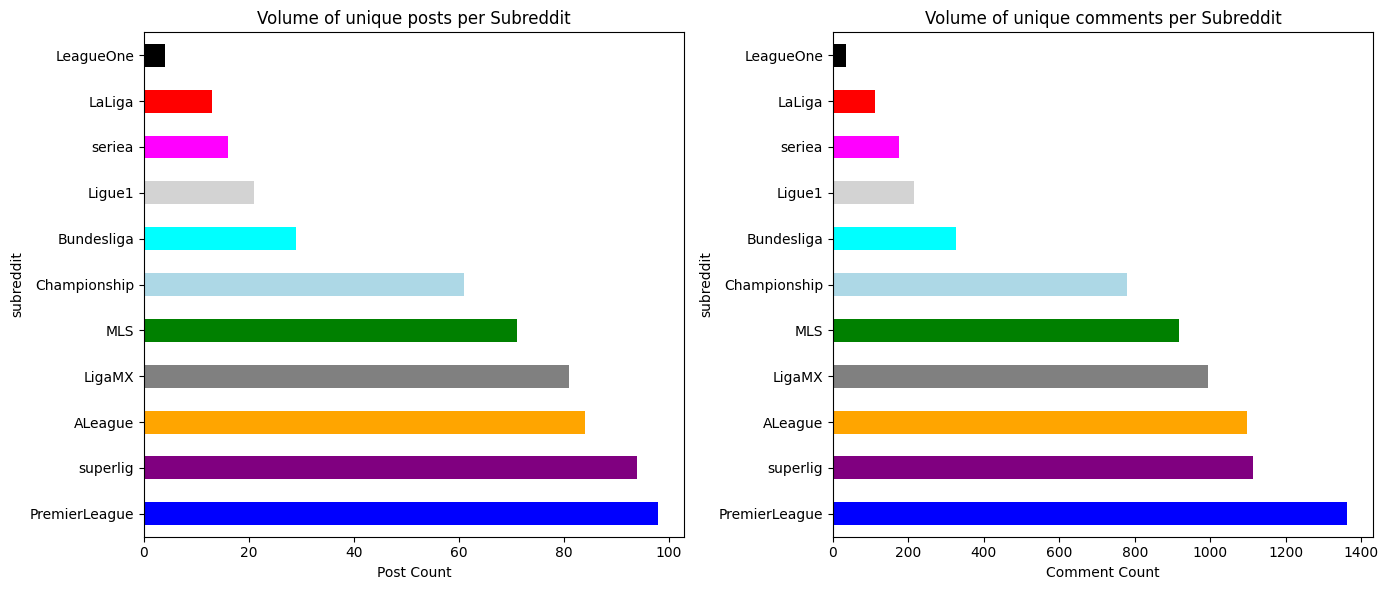

In [ ]:
data = pd.read_csv("../data/outputs/reddit_data_VAR_100p_15c_13sr_preprocessed.csv")

fig = plt.figure(figsize=(14, 6))
ax1, ax2 = fig.subplots(ncols=2)

# Subreddit Post Counts
subr_p_counts = data[["title_preprocessed", "subreddit"]].drop_duplicates().subreddit.value_counts()
subr_p_colours = [colour_map[nm] for nm in subr_p_counts.index]
subr_p_counts.plot(kind="barh", color=subr_p_colours, ax=ax1)
ax1.set_title("Volume of unique posts per Subreddit")
ax1.set_xlabel("Post Count")

# Subreddit Comment Counts
subr_c_counts = data[["comment_content_preprocessed", "subreddit"]].drop_duplicates().subreddit.value_counts()
subr_c_colours = [colour_map[nm] for nm in subr_c_counts.index]
subr_c_counts.plot(kind="barh", color=subr_c_colours, ax=ax2)
ax2.set_title("Volume of unique comments per Subreddit")
ax2.set_xlabel("Comment Count")

fig.tight_layout()